# Active Image Classification via Self-supervised Learning

This tutorial aims to demonstrate a practical comparison study using our ```scikit-activeml``` library. The workflow involves utilizing a self-supervised learning model, specifically ```DINOv2``` from [1], to generate embeddings for the Flowers-102 dataset [2]. Subsequently, various active learning strategies will be employed to intelligently select samples for labeling.

**Key Steps:**
1. **Self-Supervised Learning Model:** Utilize the DINOv2 model to create embedding dataset for Flowers-102 dataset.

2. **Active Learning Strategies:** Employ different active learning strategies provided by our library, including:
    - Random Sampling
    - Uncertainty Sampling
    - Discriminative Active Learning (DiscriminativeAL)
    - CoreSet
    - TypiClust
    - Badge

3. **Batch Sample Selection:** Use each active learning strategy to select a batch of samples for labeling.

4. **Plotting the results:** By the end of this notebook, we'll compare the accuracy of the aforementioned active learning strategies.

**References:**

[1] M. Oquab et al., ‘DINOv2: Learning Robust Visual Features without Supervision’. Transactions on Machine Learning Research (TMLR)

[2] M. E. Nilsback and A. Zisserman, 'Automated Flower Classification over a Large Number of Classes'. Indian Conference on Computer Vision, Graphics and Image Processing (ICVGIP)

**Import Packages**

First, let's import the packages we will need for this project.

In [1]:
#!pip install torch torchvision torchaudio tqdm

In [3]:
import numpy as np
import matplotlib as mlp
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression

from skactiveml.classifier import SklearnClassifier
from skactiveml.pool import UncertaintySampling, RandomSampling, DiscriminativeAL, CoreSet, TypiClust, Badge
from skactiveml.utils import call_func, MISSING_LABEL

import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from tqdm import tqdm

import warnings
mlp.rcParams["figure.facecolor"] = "white"
warnings.filterwarnings("ignore")

## Prepare Data with DINOv2

In this step, we focus on preparing the datasets using the self-supervised learning model DINOv2. DINOv2, short for "self-distillation with no labels", is a state-of-the-art model that excels at learning meaningful representations from unlabeled data.

If you've already completed these steps, you can skip ahead to loading your data. 

**Step 1: Transformation**

Apply necessary transformations to the datasets, including resizing images to a standardized format. This ensures consistency of input dimensions with the DINOv2 model.

In [4]:
transforms = transforms.Compose(
        [transforms.Resize(256),
         transforms.CenterCrop(224),
         transforms.ToTensor(),
         transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))]
    )

**Step 2: Load pretrained Model**
To calculate embeddings, we'll use DINOv2. Below we load the second smallest DINOv2 model to generate embedding datasets for the Flowers-102 datasets. 

In [10]:
torch.hub.set_dir('cache/')

dinov2_vitb14 = torch.hub.load("facebookresearch/dinov2", "dinov2_vitb14")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

dinov2_vitb14.to(device)

Downloading: "https://github.com/facebookresearch/dinov2/zipball/main" to cache/main.zip
Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vitb14/dinov2_vitb14_pretrain.pth" to cache/checkpoints/dinov2_vitb14_pretrain.pth
100%|██████████| 330M/330M [00:58<00:00, 5.88MB/s] 


DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-11): 12 x NestedTensorBlock(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
      (drop_path2): Identity()
    )
  )
  (n

**Step 3: Load Datasets and Generate Embeddings**

Firstly, we begin by loading the Flowers-102 dataset.

After that, we employ the pre-trained DINOv2 model to generate embeddings for each image in the dataset and save them in a npy file.

In [12]:
def load_and_process_dataset(root_dir, is_train, batch_size=4):
    """
    Load and process a given dataset for training or validation.

    Parameters:
    - root_dir (str) : Root directory where the dataset will be stored.
    - is_train (bool) : Boolean indicating whether the dataset is for training (True) or validation (False).
    - batch_size (int) : The batch_size used for the DataLoader.

    Returns:
    - X (numpy.ndarray): Concatenated embeddings of the dataset.
    - y_true (numpy.ndarray): Concatenated true labels of the dataset.
    """
    
    # Load dataset
    if is_train:
        split = 'train'
    else:
        split = 'val'
    
    dataset = datasets.Flowers102(root=root_dir, split=split, download=True, transform=transforms)
        

    # Create DataLoader
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=is_train, num_workers=2)

    embedding_list = []
    label_list = []
    
    # Iterate through the DataLoader and extract embeddings
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total=len(dataloader), desc=f"Flowers102 {split}"):
            image, label = data
            embeddings = dinov2_vitb14(image.to(device)).cpu()
            embedding_list.append(embeddings)
            label_list.append(label)

        # Concatenate embeddings and labels
        X = torch.cat(embedding_list, dim=0).numpy()
        y_true = torch.cat(label_list, dim=0).numpy()

    return X, y_true

Applying on Flowers102 Datasets

In [13]:
data_dir = "./data"

In [15]:
# Flowers-102
flowers102_X_train, flowers102_y_train_true = load_and_process_dataset(data_dir, True)
flowers102_X_test, flowers102_y_test_true = load_and_process_dataset(data_dir, False)

np.save(f'{data_dir}/flowers102_dinov2B_X_train.npy', flowers102_X_train)
np.save(f'{data_dir}/flowers102_dinov2B_y_train.npy', flowers102_y_train_true)
np.save(f'{data_dir}/flowers102_dinov2B_X_test.npy', flowers102_X_test)
np.save(f'{data_dir}/flowers102_dinov2B_y_test.npy', flowers102_y_test_true)

Flowers102 val: 100%|██████████| 255/255 [01:44<00:00,  2.45it/s]


## Load your preprocessed Dataset

If you have previously processed your data with DINOv2, please use the following code to load your data. And we also define the number of classes in the Flowers102 dataset.

In [16]:
data_dir = "./data"

In [18]:
# Flowers-102
X_train = np.load(f'{data_dir}/flowers102_dinov2B_X_train.npy')
y_train_true = np.load(f'{data_dir}/flowers102_dinov2B_y_train.npy')
X_test = np.load(f'{data_dir}/flowers102_dinov2B_X_test.npy')
y_test_true = np.load(f'{data_dir}/flowers102_dinov2B_y_test.npy')

dataset_classes = 102

## Random Seed Management

To ensure experiment reproducibility, it's important to set random states for all components that might use them. For simplicity, we set a single fixed random state and use helper functions to generate new seeds and random states. It's important to note that the ```master_random_state``` should only be used to create new random states or random seeds.

In [19]:
master_random_state = np.random.RandomState(0)

def gen_seed(random_state:np.random.RandomState):
    """
    Generate a seed for a random number generator.

    Parameters:
    - random_state (np.random.RandomState): Random state object.

    Returns:
    - int: Generated seed.
    """
    return random_state.randint(0, 2**31)

def gen_random_state(random_state:np.random.RandomState):
    """
    Generate a new random state object based on a given random state.

    Parameters:
    - random_state (np.random.RandomState): Random state object.

    Returns:
    - np.random.RandomState: New random state object.
    """
    return np.random.RandomState(gen_seed(random_state))

## Classification Models and Query Strategies

The embeddings we have computed can be used as an input to a classification model. For this guide, we use `LogisticRegression` from `sklearn`. Moreover, we handle the creation of query strategies using factory functions to simplify the separation of query strategies across repetitions.

In [20]:
clf = SklearnClassifier(LogisticRegression(), classes=np.arange(dataset_classes), random_state=gen_seed(master_random_state))

def create_query_strategy(name, random_state):
    return query_strategy_factory_functions[name](random_state)

query_strategy_factory_functions = {
    'RandomSampling': lambda random_state: RandomSampling(random_state=gen_seed(random_state)),
    'UncertaintySampling': lambda random_state: UncertaintySampling(random_state=gen_seed(random_state)),
    'DiscriminativeAL': lambda random_state: DiscriminativeAL(random_state=gen_seed(random_state)),
    'CoreSet': lambda random_state: CoreSet(random_state=gen_seed(random_state)),
    'TypiClust': lambda random_state: TypiClust(random_state=gen_seed(random_state)),
    'Badge': lambda random_state: Badge(random_state=gen_seed(random_state))
}

## Experiment Parameters

For this experiment, we need to define how the strategies should be compared against one another. Here the number of repetitions (```n_reps```), the number of cycles (```n_cycles```), and the size of each query (```query_batch_size```) need to be defined. 

In [21]:
n_reps = 3
n_cycles = 30
query_batch_size = 8
query_strategy_names = query_strategy_factory_functions.keys()

## Experiment Loop

The actual experiment loops over all query strategies. The accuracy for the test set is stored for each cycle and repetition in the `results` dictionary.

In [22]:
results = {}

for qs_name in query_strategy_names:
    accuracies = np.full((n_reps, n_cycles), np.nan)
    for i_rep in range(n_reps):
        y_train = np.full(shape=y_train_true.shape, fill_value=MISSING_LABEL)
    
        qs = create_query_strategy(qs_name, random_state=gen_random_state(np.random.RandomState(i_rep)))
        clf.fit(X_train, y_train)
        
        for c in tqdm(range(n_cycles), desc=f'Repeat {i_rep + 1} with {qs_name}'):
            query_idx = call_func(qs.query, X=X_train, y=y_train, batch_size=query_batch_size, clf=clf, discriminator=clf)
            y_train[query_idx] = y_train_true[query_idx]
            clf.fit(X_train, y_train)
            score = clf.score(X_test, y_test_true)
            accuracies[i_rep, c] = score
    
    results[qs_name] = accuracies

Repeat 3 with Badge: 100%|██████████| 30/30 [01:02<00:00,  2.07s/it]


## Resulting Plotting

We use learning curves to compare strategies. We visualize the average accuracy over all repetitions. In addition, the legend provides insight into the area under the learning curve, which indicates the average accuracy over all cycles.

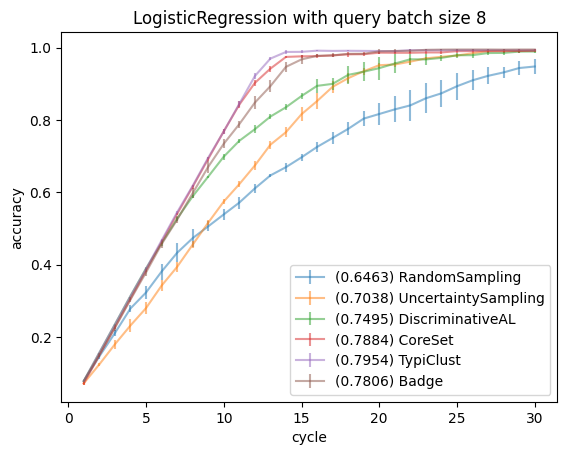

In [23]:
for qs_name in query_strategy_names:
    key = qs_name
    result = results[key]
    reshaped_result = result.reshape((-1, n_cycles))
    errorbar_mean = np.mean(reshaped_result, axis=0)
    errorbar_std = np.std(reshaped_result, axis=0)
    plt.errorbar(np.arange(1, n_cycles+1), errorbar_mean, errorbar_std, label=f"({np.mean(errorbar_mean):.4f}) {qs_name}", alpha=0.5)
plt.title(f"LogisticRegression with query batch size {query_batch_size}")
plt.legend(loc='lower right')
plt.xlabel('cycle')
plt.ylabel('accuracy')
plt.show()